## Imports

In [219]:
import tensorflow as tf
from keras import datasets
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from time import sleep
import cv2
import pandas as pd


## Loading the data

### 1. Listing images in the dataset directory

In [50]:
# # Devasheesh's faces
# deva_faces = './data/devasheesh/'
# deva_faces = os.listdir(deva_faces)
# deva_faces = [deva_faces[i] for i in range(len(deva_faces)) if deva_faces[i].endswith('.jpg')]

# # Swarnim's faces
# swar_faces = './data/swarnim/'
# swar_faces = os.listdir(swar_faces)
# swar_faces = [swar_faces[i] for i in range(len(swar_faces)) if swar_faces[i].endswith('.jpg')]

# # Negative faces
# neg_faces = './data/negative-faces/'
# neg_faces = os.listdir(neg_faces)
# neg_faces = [neg_faces[i] for i in range(len(neg_faces)) if neg_faces[i].endswith('.jpg')]

# Making a function to list all the images in a folder
def list_images(path):
    image_files = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))
    return image_files

deva_faces = list_images('.\\data\\devasheesh\\')
swar_faces = list_images('.\\data\\swarnim\\')
neg_faces = list_images('.\\data\\negative-faces\\')

### 2. Making Train and Test Objects

In [332]:
# function to extract the face from the image
# using the Haar Cascade Classifier
def extract_frontal_face_harr(image_ndarray, grayscale=True, size=(150, 150)):
    # Load the cascade
    face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
    # Convert into grayscale
    if grayscale:
        image_gray = cv2.cvtColor(image_ndarray, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image_ndarray
    # Detect faces
    faces_cord = face_cascade.detectMultiScale(image_gray, 1.3, 5)
    # Return the face or None if not found
    if len(faces_cord) == 0:
        return None, None
    # Extract the face
    (x, y, w, h) = faces_cord[0]
    # Resize the image to 150x150
    image_gray_resized = cv2.resize(image_gray[y:y+w, x:x+h], size)
    # Return only the face part of the image
    return image_gray_resized, faces_cord

# using DNN
modelFile = "dnn/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "dnn/deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

def extract_frontal_face(image_ndarray, grayscale=True, size=(150, 150)):
    # Load the extractor
    (h, w) = image_ndarray.shape[:2]
    blob = cv2.dnn.blobFromImage(image_ndarray, 1.0, (300, 300), (104.0, 177.0, 123.0))
    # Convert into grayscale
    if grayscale:
        image_gray = cv2.cvtColor(image_ndarray, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image_ndarray
    # Detect faces
    net.setInput(blob)
    detections = net.forward()
    faces_cord = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, w, h) = box.astype("int")
            faces_cord.append([x, y, w, h])
    
    # Return the face or None if not found
    if len(faces_cord) == 0:
        return None, None
    
    # Extract the face
    (x, y, w, h) = faces_cord[0]

    # Resize the image to 150x150
    image_gray_resized = cv2.resize(image_gray[y:y+w, x:x+h], size)

    # Return only the face part of the image
    return image_gray_resized, faces_cord


In [333]:
# function to make the image size uniform and make train and test object with labels
class dataframe():
    def __init__(self):
        self.deva_faces = deva_faces
        self.swar_faces = swar_faces
        self.neg_faces = neg_faces
        self.images, self.labels = list(), list()

        self.total_images = len(deva_faces)+len(swar_faces)+len(neg_faces)
        self.labels_list = ['Unknown', 'Devasheesh', 'Swarnim']

        print('Total images: ', self.total_images)

        self.datagen = ImageDataGenerator(
            rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
            shear_range=0.2,    # set range for random shear
            zoom_range=0.2,    # set range for random zoom
            horizontal_flip=True,   # randomly flip images
            fill_mode='nearest' # set mode for filling points outside the input boundaries
        )

    def append_dataframe(self, images_list, label, augment=False):
        for image_adr in images_list:
            # read the image
            image = cv2.imread(image_adr)
            # extract the face
            face, _ = extract_frontal_face(image, grayscale=False, size=(150, 150))

            if face is not None:
                # print('Face type: ', type(face))
                # print('Image shape: ', image.shape)
                # print('Face shape: ', face.shape)
                # print('Face: ', plt.imshow(face))

                # append the face image to the list
                if augment:
                    # using the image data generator to augment the images
                    i = 0
                    for batch in self.datagen.flow(face.reshape(1, 150, 150, 3), batch_size=1):
                        # append the image to the list
                        self.images.append(batch[0])
                        self.labels.append(label)
                        i += 1
                        if i > 10:
                            break
                else:
                    self.images.append(face)
                    self.labels.append(label)
            else:
                print(f'Face not found in {image_adr}')
                continue
    
    def make_dataframe(self):
        self.append_dataframe(self.neg_faces[:10], '0', augment=False)
        self.append_dataframe(self.deva_faces[:60], '1', augment=False)
        self.append_dataframe(self.swar_faces[:5], '2', augment=False)
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)
        print('Images shape: ', self.images.shape)
        print('Labels shape: ', self.labels.shape)
        return self.images/255.0, self.labels, self.labels_list

x = dataframe()
images, labels, labels_list = x.make_dataframe()

Total images:  5240


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


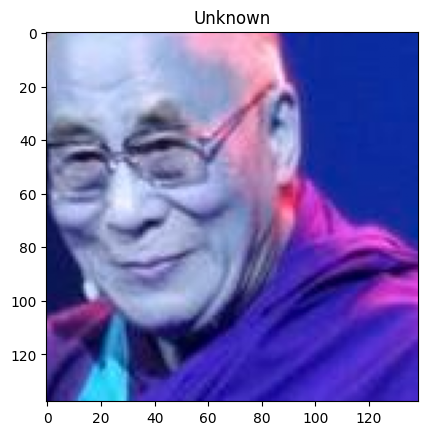

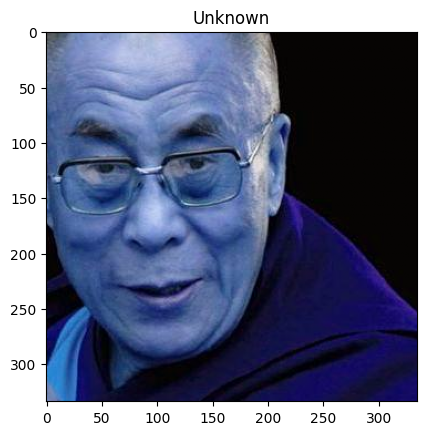

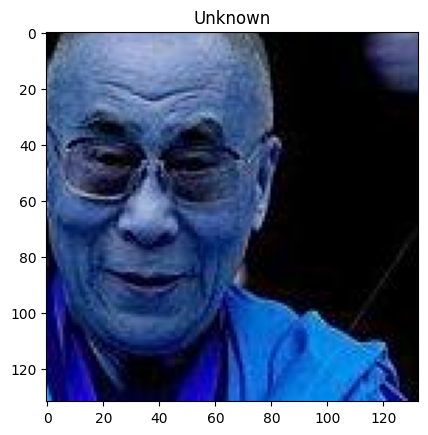

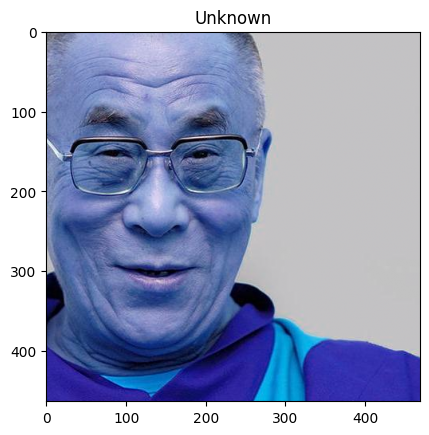

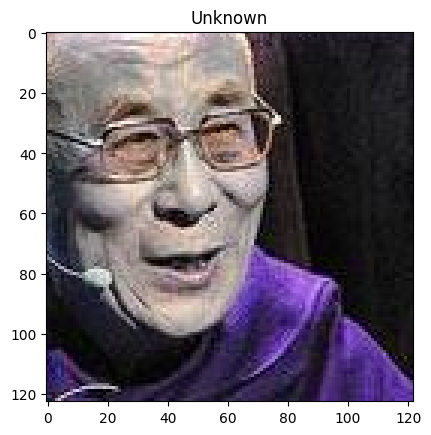

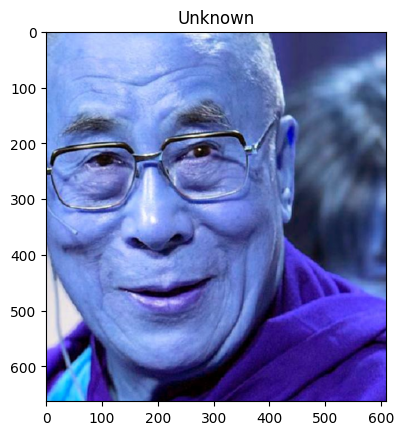

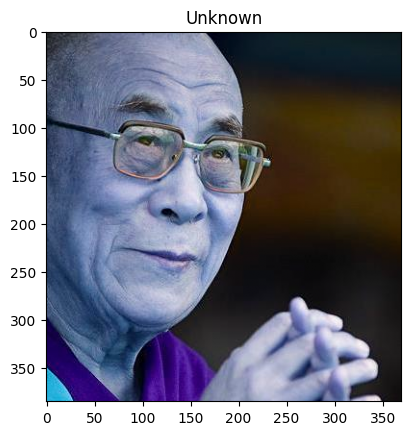

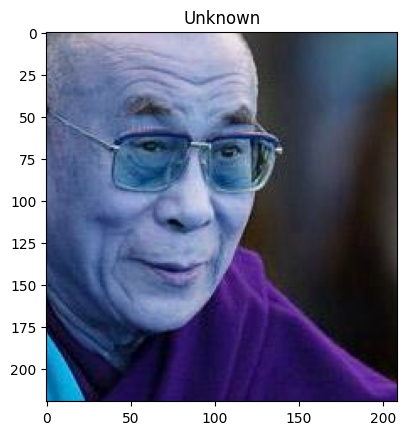

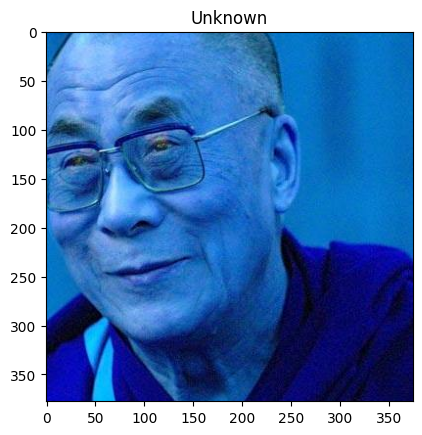

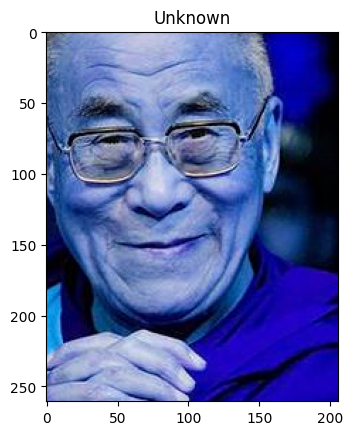

Error in 10
Error in 11
Error in 12
Error in 13
Error in 14
Error in 15
Error in 16
Error in 17
Error in 18
Error in 19
Error in 20
Error in 21
Error in 22
Error in 23
Error in 24
Error in 25
Error in 26


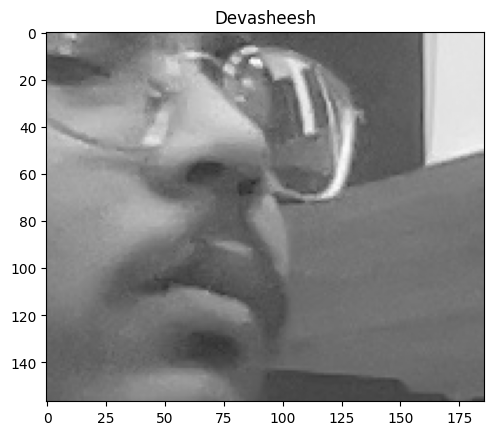

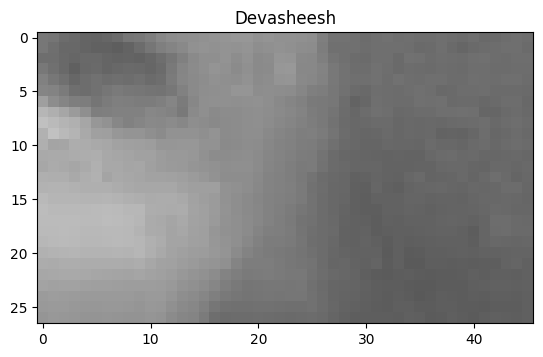

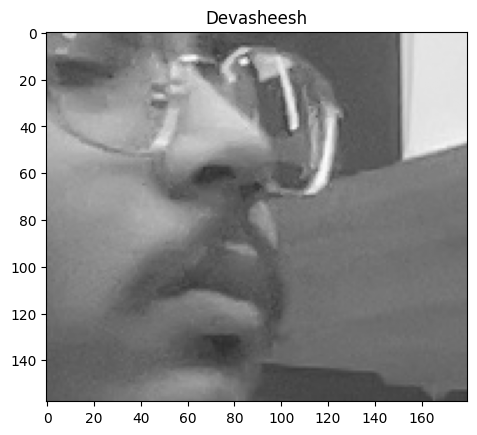

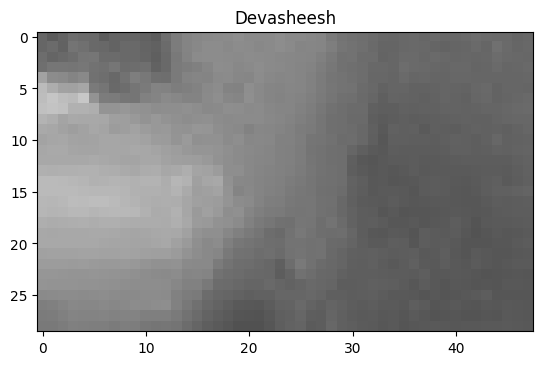

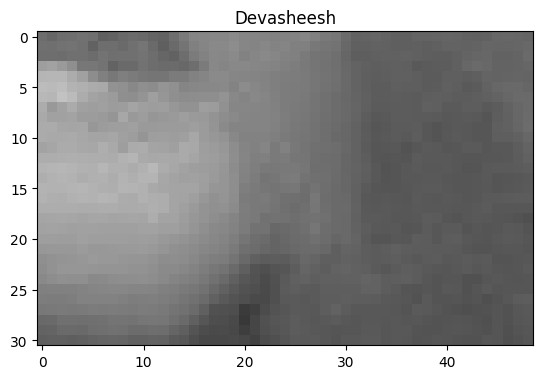

Error in 32
Error in 33
Error in 34
Error in 35
Error in 36
Error in 37
Error in 38
Error in 39


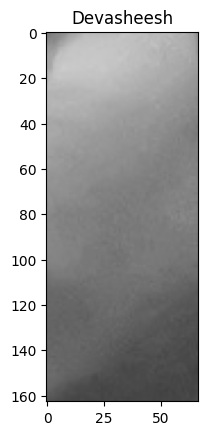

Error in 41
Error in 42
Error in 43
Error in 44
Error in 45
Error in 46
Error in 47
Error in 48
Error in 49
Error in 50
Error in 51
Error in 52
Error in 53
Error in 54
Error in 55
Error in 56
Error in 57
Error in 58
Error in 59
Error in 60
Error in 61
Error in 62
Error in 63
Error in 64
Error in 65


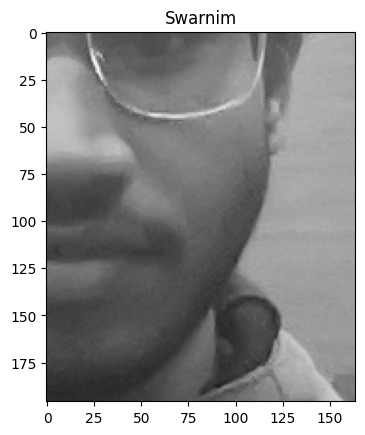

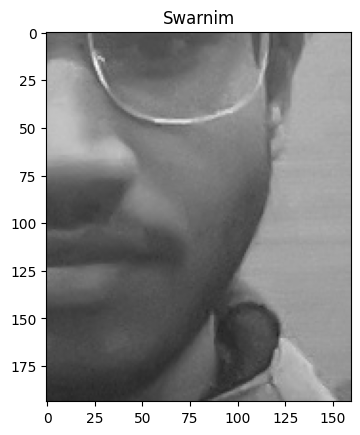

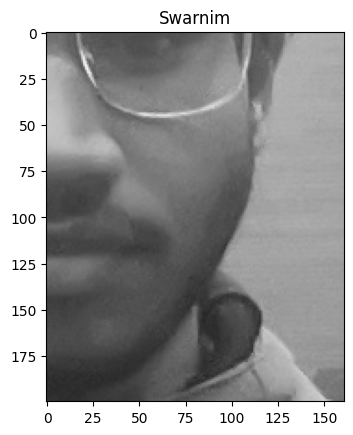

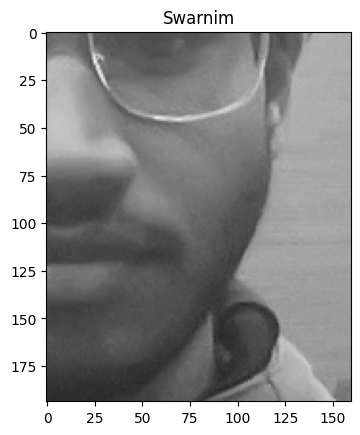

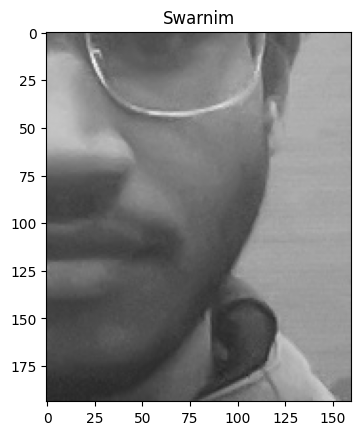

Error in 71


In [331]:
for x in range(72):
    try:
        plt.imshow(images[x])
        plt.title(labels_list[int(labels[x])])
        plt.show()
    except:
        print(f'Error in {x}')
# images

In [325]:
deva_faces[:5]


['.\\data\\devasheesh\\Devasheesh_142.jpg',
 '.\\data\\devasheesh\\Devasheesh_143.jpg',
 '.\\data\\devasheesh\\Devasheesh_144.jpg',
 '.\\data\\devasheesh\\Devasheesh_145.jpg',
 '.\\data\\devasheesh\\Devasheesh_146.jpg']

In [240]:
# load cifar10 dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# plt.imshow(train_images[543], cmap='gray')
# label
# plt.title(labels[train_labels[543][0]])
# plt.show()
train_images

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        